<a href="https://colab.research.google.com/github/sunnywithcurlyhair/DS_Project_5/blob/main/BERT_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard

from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
%run drive/MyDrive/Colab\ Notebooks/DS_Phase_5/data_wrangling_colab.py

The agreement was signed with Biohit Healthcare Ltd , the UK-based subsidiary of Biohit Oyj , a Finnish public company which develops , manufactures and markets liquid handling products and diagnostic test systems .


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(89642,)
!
"
#
$
%
&
'
(
)
*
+
,
-
.
/
:
;
<
=
>
?
@
[
\
]
^
_
`
{
|
}
~
Altia a False
's ' False
operating o False
profit p False
jumped j False
to t False
EUR e False
47 4 True
million m False
from f False
EUR e False
6.6 6 True
million m False
. . False
(47478,)
(89642,)
Final corpus contains 45051 words, with 7265 unique values in the dictionary


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_bert_embedding(doc):
  preprocessed_text = bert_preprocess(doc)
  return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
X_trainval = train_df['sentence']
y_trainval = train_df['label']
X_test = test_df['sentence']
y_test = test_df['label']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42,stratify=y_trainval)

In [ ]:
X_train

700     firm 28 October 2009 - Finnish lifting equipme...
1218    Stock Exchange Release 10/3/2011 12:00 Sanoma ...
608     Finnair expands : Finnair plans to add more fl...
2699    Operating profit rose to EUR2 .4 m from EUR1 ....
2259    Based on strong customer interest and feedback...
                              ...                        
3744    Cash flow from operations totalled EUR 2.71 mn...
3216    In addition , Cramo and Peab have signed exclu...
2711    Our standardised services have met with a posi...
722     `` Overall , we 're pleased with the startup c...
3064    Operating profit was EUR 24.5 mn , up from EUR...
Name: sentence, Length: 3101, dtype: object

In [ ]:
print(f"""train set distribution
{y_train.value_counts(normalize=True)}
val set distribution
{y_val.value_counts(normalize=True)}
test set distribution
{y_test.value_counts(normalize=True)}""")

train set distribution
1    0.598517
2    0.277652
0    0.123831
Name: label, dtype: float64
val set distribution
1    0.597938
2    0.278351
0    0.123711
Name: label, dtype: float64
test set distribution
1    0.576883
2    0.295150
0    0.127967
Name: label, dtype: float64


In [ ]:
# building functional neutral network to include bert layers for preprocess and encoding, and dense layers for classification
inputs = Input(shape=(), dtype=tf.string, name='sentence')
preprocessed_text = bert_preprocess(inputs)
outputs = bert_encoder(preprocessed_text)

layer=Dropout(0.2, name="dropout")(outputs['pooled_output'])
layer=BatchNormalization(name="batchnorm")(layer)
layer=Dense(3, activation='softmax', name="output")(layer)
model = tf.keras.Model(inputs=inputs, outputs=layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sentence (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['sentence[0][0]']            
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
bert_poold_checkpoint_path = "drive/MyDrive/Colab Notebooks/DS_Phase_5/bert_poold"

bert_poold_checkpoint = ModelCheckpoint(filepath=bert_poold_checkpoint_path,
                                        save_weights_only=False,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

In [ ]:
bert_poold_output = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32,epochs=30,callbacks=[bert_poold_checkpoint])

Epoch 1/30
97/97 [==============================] - 41s 329ms/step - loss: 1.1493 - accuracy: 0.4940 - val_loss: 0.8514 - val_accuracy: 0.6469
Epoch 2/30
97/97 [==============================] - 27s 281ms/step - loss: 0.9325 - accuracy: 0.5930 - val_loss: 0.7753 - val_accuracy: 0.6624
Epoch 3/30
97/97 [==============================] - 28s 291ms/step - loss: 0.8927 - accuracy: 0.6014 - val_loss: 0.7288 - val_accuracy: 0.6881
Epoch 4/30
97/97 [==============================] - 28s 288ms/step - loss: 0.8023 - accuracy: 0.6350 - val_loss: 0.6903 - val_accuracy: 0.6933
Epoch 5/30
97/97 [==============================] - 28s 293ms/step - loss: 0.8148 - accuracy: 0.6282 - val_loss: 0.6802 - val_accuracy: 0.7062
Epoch 6/30
97/97 [==============================] - 29s 302ms/step - loss: 0.7630 - accuracy: 0.6533 - val_loss: 0.6557 - val_accuracy: 0.7255
Epoch 7/30
97/97 [==============================] - 16s 160ms/step - loss: 0.7519 - accuracy: 0.6701 - val_loss: 0.6832 - val_accuracy: 0.6856

In [ ]:
bert_poold_best_model=tf.keras.models.load_model(bert_poold_checkpoint_path)

In [ ]:
bert_poold_best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sentence (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['sentence[0][0]']            
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
bert_poold_best_model.evaluate(X_test, y_test)

31/31 [==============================] - 5s 124ms/step - loss: 0.6147 - accuracy: 0.7327


[0.61471027135849, 0.7327141165733337]

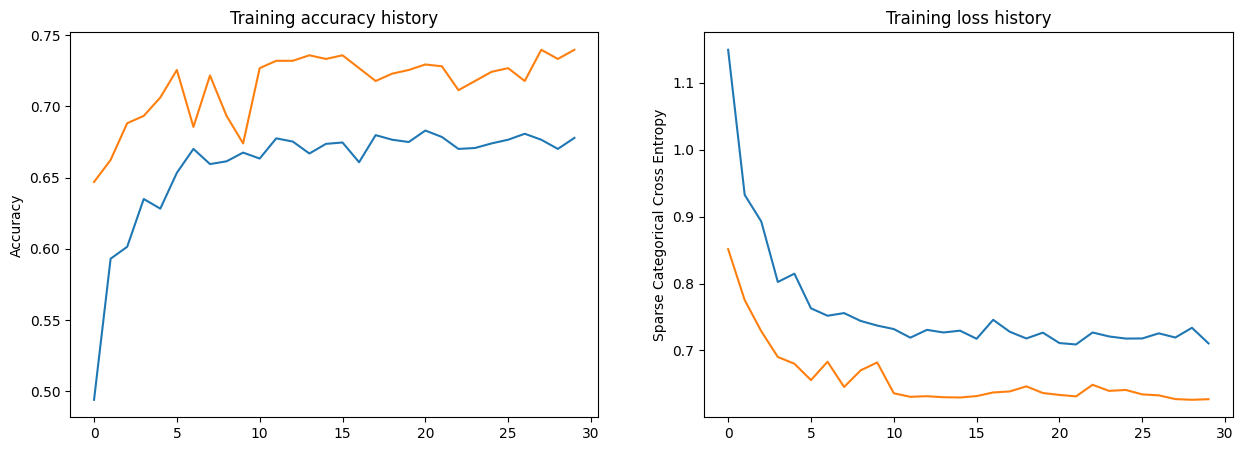

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
bert_poold_output_history=pd.DataFrame(bert_poold_output.history)
bert_poold_output_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(bert_poold_output_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(bert_poold_output_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

In [ ]:
def schedual_lr(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(schedual_lr)


In [ ]:
bert_poold_output_contd = bert_poold_best_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32,epochs=50,callbacks=[bert_poold_checkpoint,lr_callback])

Epoch 1/50
97/97 [==============================] - 38s 295ms/step - loss: 0.7078 - accuracy: 0.6682 - val_loss: 0.6252 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 2/50
97/97 [==============================] - 27s 283ms/step - loss: 0.7201 - accuracy: 0.6704 - val_loss: 0.6328 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/50
97/97 [==============================] - 16s 161ms/step - loss: 0.7213 - accuracy: 0.6720 - val_loss: 0.6403 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 4/50
97/97 [==============================] - 16s 161ms/step - loss: 0.7176 - accuracy: 0.6811 - val_loss: 0.6263 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 5/50
97/97 [==============================] - 15s 159ms/step - loss: 0.7270 - accuracy: 0.6749 - val_loss: 0.6344 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 6/50
97/97 [==============================] - 15s 160ms/step - loss: 0.7257 - accuracy: 0.6688 - val_loss: 0.6289 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 7/50
97/97 [==============================] - 15s 160ms/st

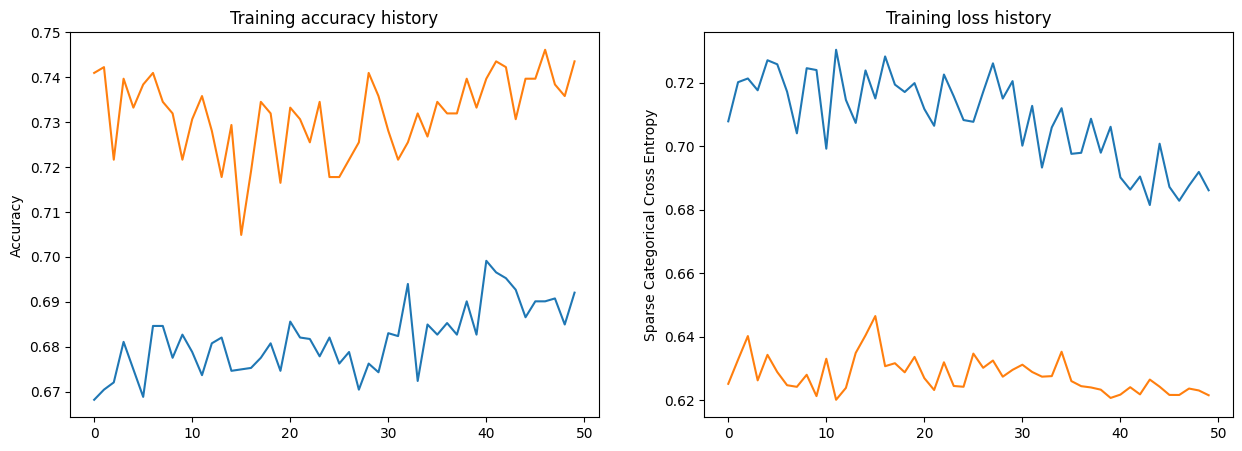

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
bert_poold_output_contd_history=pd.DataFrame(bert_poold_output_contd.history)
bert_poold_output_contd_history.index.name='epochs'
accuracy_col_list = ['accuracy', 'val_accuracy']
loss_col_list = ['loss', 'val_loss']
ax[0].plot(bert_poold_output_contd_history[accuracy_col_list])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy history')
ax[1].plot(bert_poold_output_contd_history[loss_col_list])
ax[1].set_ylabel('Sparse Categorical Cross Entropy')
ax[1].set_title('Training loss history')
plt.show()

In [ ]:
bert_poold_best_model=tf.keras.models.load_model(bert_poold_checkpoint_path)
bert_poold_best_model.evaluate(X_test, y_test)

31/31 [==============================] - 5s 124ms/step - loss: 0.6161 - accuracy: 0.7255


[0.6160744428634644, 0.7254902124404907]

In [ ]:
bert_poold_best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sentence (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['sentence[0][0]']            
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
tb_callback=TensorBoard(log_dir='drive/MyDrive/Colab Notebooks/DS_Phase_5/bert_poold/log')
early_stop=EarlyStopping(monitor='val_loss',min_delta = 1e-6, patience = 5)

In [ ]:
bert_poold_output_contd_1 = bert_poold_best_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32,epochs=100,callbacks=[bert_poold_checkpoint,early_stop,lr_callback,tb_callback])

Epoch 1/100
97/97 [==============================] - 28s 160ms/step - loss: 0.6935 - accuracy: 0.6843 - val_loss: 0.6234 - val_accuracy: 0.7423 - lr: 1.8268e-04
Epoch 2/100
97/97 [==============================] - 15s 160ms/step - loss: 0.7004 - accuracy: 0.6882 - val_loss: 0.6260 - val_accuracy: 0.7358 - lr: 1.8268e-04
Epoch 3/100
97/97 [==============================] - 15s 159ms/step - loss: 0.6918 - accuracy: 0.6866 - val_loss: 0.6264 - val_accuracy: 0.7358 - lr: 1.8268e-04
Epoch 4/100
97/97 [==============================] - 15s 159ms/step - loss: 0.6978 - accuracy: 0.6878 - val_loss: 0.6261 - val_accuracy: 0.7397 - lr: 1.8268e-04
Epoch 5/100
97/97 [==============================] - 15s 159ms/step - loss: 0.6868 - accuracy: 0.6885 - val_loss: 0.6233 - val_accuracy: 0.7384 - lr: 1.8268e-04
Epoch 6/100
97/97 [==============================] - 15s 160ms/step - loss: 0.6955 - accuracy: 0.6862 - val_loss: 0.6232 - val_accuracy: 0.7371 - lr: 1.8268e-04
Epoch 7/100
97/97 [===============

In [ ]:
bert_poold_best_model=tf.keras.models.load_model(bert_poold_checkpoint_path)
bert_poold_best_model.evaluate(X_test, y_test)

31/31 [==============================] - 5s 124ms/step - loss: 0.6161 - accuracy: 0.7255


[0.6160744428634644, 0.7254902124404907]

In [ ]:


model.save('model.h5')
files.download('model.h5')
